# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/carbon_network/build')

import build_tools as wt

# replace with submodules
import sys
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft
sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink

import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [2]:
all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/all_spectra_backup.pkl')


In [15]:

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [4]:
uni_df = pd.read_csv('Zark_Dittmar_DOM_struct-fingerpr.tab', sep='\t',skiprows=20)
len(uni_df['Formula (of source compound)'].unique())
# uni_df.columns

54

In [65]:
spec_slice = all_df[all_df['predicted_formula']=='C16H14O10'].copy()
spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
data_pmzs = spec_slice['precursor_mz'].tolist()
data_pmzs[0]

365.0505041699762

In [76]:
54/9

6.0

In [22]:

spec_slice = all_df[all_df['predicted_formula'].isin(uni_df['Formula (of source compound)'])].copy()
spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
spec_slice = spec_slice[spec_slice['num_frags']>4]
spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
spec_slice.drop_duplicates(subset=['dataset','predicted_formula'],inplace=True)

# get all unique pairs in spec_slice['dataset'] using itertools combinations
# for each pair, get the cosine similarity of the two spectra
from itertools import combinations
unique_pairs = combinations(spec_slice['dataset'].unique(),2)
unique_pairs = list(unique_pairs)
unique_pairs[0]

('MSV000092487', 'MSV000085555')

In [29]:

# get cosine similarity for each pair
out = []
for pair in unique_pairs:
    cols = ['mdm_mz_vals','mdm_i_vals']
    spec_slice1 = spec_slice[spec_slice['dataset']==pair[0]].copy()
    spec_slice2 = spec_slice[spec_slice['dataset']==pair[1]].copy()
    if (spec_slice1.shape[0]<3) | (spec_slice2.shape[0]<3):
        continue
    spec_slice1.reset_index(inplace=True,drop=True)
    spec_slice2.reset_index(inplace=True,drop=True)
    pmz1 = spec_slice.loc[spec_slice['dataset']==pair[0],'precursor_mz'].tolist()
    pmz2 = spec_slice.loc[spec_slice['dataset']==pair[1],'precursor_mz'].tolist()

    spec1 = spec_slice.loc[spec_slice['dataset']==pair[0],cols].apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1).tolist()
    spec2 = spec_slice.loc[spec_slice['dataset']==pair[1],cols].apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1).tolist()
    # cosine_similarities.append([pair[0],pair[1],at.cosine_similarity(spec1['spectrum_nl_spectra'],spec2['spectrum_nl_spectra'])])
    nl_spec1 = []
    nl_spec2 = []
    for s,pmz in zip(spec1,pmz1):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        nl_spec1.append(temp)
    for s,pmz in zip(spec2,pmz2):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        nl_spec2.append(temp)
    discretized_spectra = blink.discretize_spectra(nl_spec1, nl_spec2, pmz1,  pmz2, bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,spec_slice1,spec_slice2,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    nl_blink['dataset1'] = pair[0]
    nl_blink['dataset2'] = pair[1]
    out.append(nl_blink)

out = pd.concat(out)
out

,query,ref,score,matches,precursor_mz_exp,precursor_mz_ref,mz_diff,dataset1,dataset2
0,17,0,0.473780,5.0,367.212897,367.212930,0.087567,MSV000092487,MSV000085555
1,12,1,0.229276,6.0,367.103459,367.103092,0.998572,MSV000092487,MSV000085555
2,15,2,0.452729,2.0,369.170991,369.170824,0.451517,MSV000092487,MSV000085555
3,4,3,0.545155,3.0,365.197030,365.196468,1.539372,MSV000092487,MSV000085555
4,10,4,0.622787,6.0,369.191949,369.191635,0.848331,MSV000092487,MSV000085555
...,...,...,...,...,...,...,...,...,...
19,20,19,0.743545,6.0,379.066482,379.067267,2.071117,MSV000089688,MSV000089190
20,20,15,0.937371,13.0,365.087614,365.087933,0.874546,MSV000089688,MSV000089190
21,23,21,0.718503,4.0,365.050580,365.051462,2.417248,MSV000089688,MSV000089190
22,22,13,0.758504,7.0,367.066818,367.066588,0.626629,MSV000089688,MSV000089190


In [ ]:

    if spec_slice.shape[0]<2:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    # temp = nl_blink[nl_blink['score']>0.001].copy()
    # bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
    bins = np.linspace(0,1,20)
    # sns.ecdfplot(nl_blink['score'],ax=ax)
    out.append({'formula':uni_form,'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    ax[counter].hist(nl_blink['score'],bins=bins)
    ax[counter].set_title(uni_form)
    ax[counter].axvline(0.8,color='red')
    # ax.set_xlabel('MS2 neutral-loss spectral similarity score')
    # ax.set_ylabel('Cumulative number of pairs')
    # plt.show
    counter += 1
plt.tight_layout()


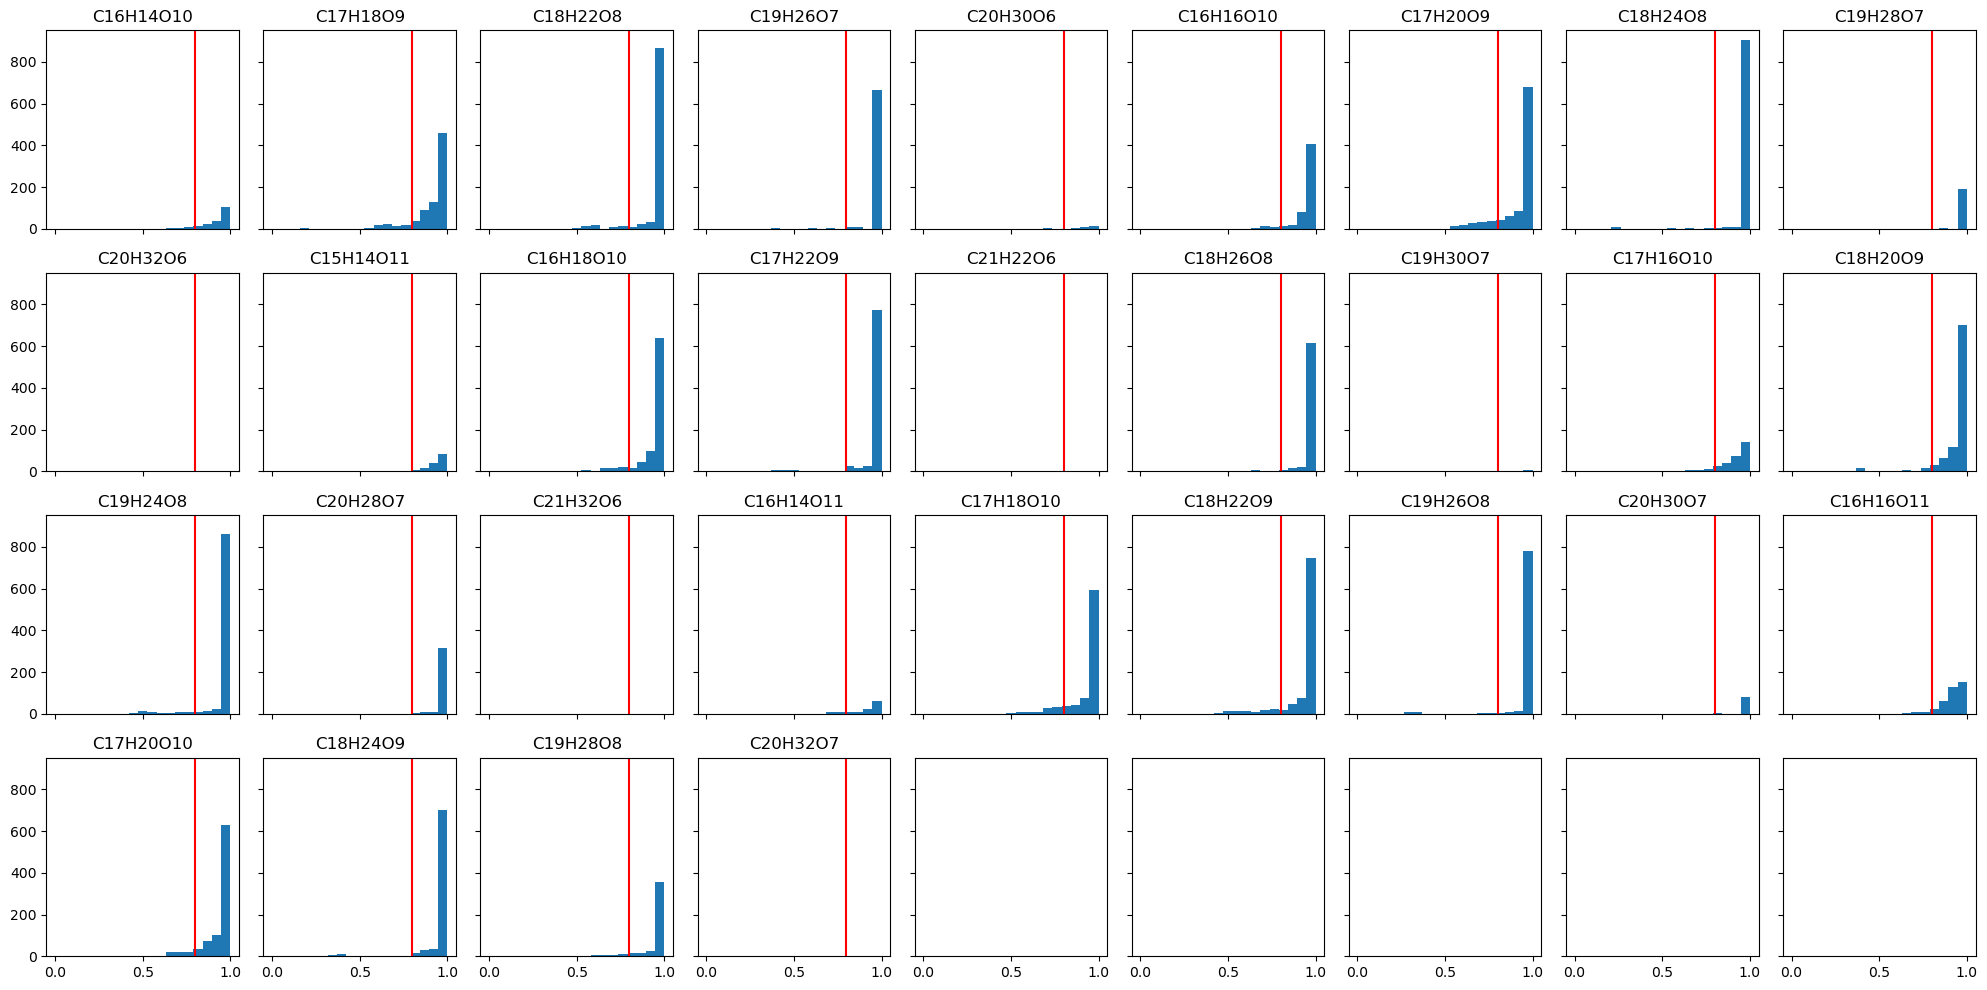

In [109]:

fig,ax = plt.subplots(ncols=9,nrows=4,figsize=(20,10),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0

out = []
for uni_form in uni_df['Formula (of source compound)'].unique():
    spec_slice = all_df[all_df['predicted_formula']==uni_form].copy()
    spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
    spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
    spec_slice = spec_slice[spec_slice['num_frags']>10]
    spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
    # spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
    # spec_slice.drop_duplicates(subset='dataset',inplace=True)
    if spec_slice.shape[0]<2:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    # temp = nl_blink[nl_blink['score']>0.001].copy()
    # bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
    bins = np.linspace(0,1,20)
    # sns.ecdfplot(nl_blink['score'],ax=ax)
    out.append({'formula':uni_form,'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    ax[counter].hist(nl_blink['score'],bins=bins)
    ax[counter].set_title(uni_form)
    ax[counter].axvline(0.8,color='red')
    # ax.set_xlabel('MS2 neutral-loss spectral similarity score')
    # ax.set_ylabel('Cumulative number of pairs')
    # plt.show
    counter += 1
plt.tight_layout()


Text(0.5, 0, 'fraction of spectra that differ by more than 80% similarity')

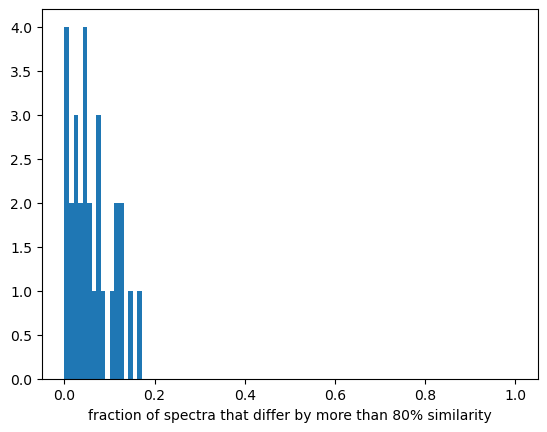

In [110]:
out = pd.DataFrame(out)
out = pd.DataFrame(out)
out['ratio'] = out['count_lt'] / (out['count_lt']+out['count_gt'])
fig,ax =plt.subplots()
bins = np.linspace(0,1,100)
ax.hist(out['ratio'],bins=bins)
ax.set_xlabel('fraction of spectra that differ by more than 80% similarity')

In [103]:

s = [g for _,g in all_df.groupby('predicted_formula')]
s = [ss for ss in s if ss.shape[0]>300]

out = []
for spec_slice in s:
    spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
    spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
    spec_slice = spec_slice[spec_slice['num_frags']>10]
    spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
    # spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
    # spec_slice.drop_duplicates(subset='dataset',inplace=True)
    if spec_slice.shape[0]<20:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    
    out.append({'formula':spec_slice.iloc[0]['predicted_formula'],'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    


Text(0.5, 0, 'fraction of spectra that differ by more than 80% similarity')

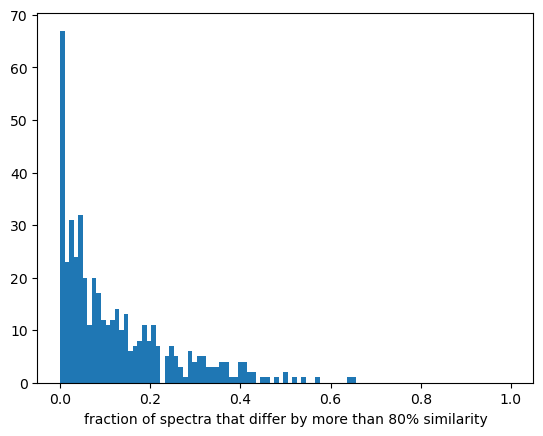

In [108]:
out = pd.DataFrame(out)
out['ratio'] = out['count_lt'] / (out['count_lt']+out['count_gt'])
fig,ax =plt.subplots()
bins = np.linspace(0,1,100)
ax.hist(out['ratio'],bins=bins)
ax.set_xlabel('fraction of spectra that differ by more than 80% similarity')

54

In [2]:

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [3]:
from importlib import reload
at = reload(at)

In [4]:
# collect and merge required data and metadata
node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing original_spectra.mgf
INFO:root:Processing nl_spectra.mgf


(6853, 9)
(6853, 9)


In [5]:
merged_node_data

,node_id,original_index,massive_id,no_extension_basename,title,description,precursor_mz,isolated_precursor_mz,rt,coisolated_precursor_count,...,spectrum_original_spectra,feature_id_nl_spectra,scans_nl_spectra,original_id_nl_spectra,pepmass_nl_spectra,precursor_mz_nl_spectra,rtinseconds_nl_spectra,charge_nl_spectra,mslevel_nl_spectra,spectrum_nl_spectra
0,847.0,847,MSV000090678,HBH0622_38_NEG,GNPS - HBH0622 Dissolved Organic Matter,DOM extraction in oceanic samples was carried ...,230.139362,230.139511,2.277,1.0,...,"[[184.87600708007812, 185.88272094726562, 184....",847,770,847,"(230.13936159781025, None)",230.139362,136.62,[1-],2,"[[168.1391143798828, 186.14947509765625, 212.1..."
1,0.0,0,MSV000092487,S56_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128534,200.128876,6.159,1.0,...,"[[138.12791442871094, 113.09635162353516, 125....",0,0,0,"(200.1285344411897, None)",200.128534,369.54,[1-],2,"[[138.12791442871094, 156.1387176513672, 182.1..."
2,3568.0,3568,MSV000092487,S13_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128543,200.128937,6.175,1.0,...,"[[138.12777709960938, 156.13873291015625, 182....",3568,2945,3568,"(200.1285431300143, None)",200.128543,370.50,[1-],2,"[[138.12777709960938, 156.13873291015625, 182...."
3,4680.0,4680,MSV000088823,DOM_Interlab-LCMS_Lab024_M_NEG_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,230.148272,230.148209,16.316,1.0,...,"[[168.1477813720703, 186.1584930419922, 212.13...",4680,3729,4680,"(230.14827249269, None)",230.148272,978.96,[1-],2,"[[168.1477813720703, 186.1584930419922, 212.13..."
4,141.0,141,MSV000088823,DOM_Interlab-LCMS_Lab16_A_Neg_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,188.056616,188.05661,1.704,1.0,...,"[[157.8631134033203, 151.8952178955078, 146.04...",141,126,141,"(188.0566155903552, None)",188.056616,102.24,[1-],2,"[[100.07701873779297, 126.05606079101562, 144...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,9722.0,9722,MSV000092487,S68_neg_1,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,208.00721,208.061356,3.51,3.0,...,"[[164.018310546875, 165.9964141845703, 177.996...",9722,6745,9722,"(208.00721005087664, None)",208.007210,210.60,[1-],2,"[[164.018310546875, 165.9964141845703, 177.996..."
6849,9756.0,9756,MSV000089061,Soil_F3A_neg,GNPS - Tuebingen Forest Soil Meta-Metabolome,Non-targeted LC-MS/MS of Soil Meta-Metabolome ...,175.035101,174.955429,13.787,2.0,...,"[[59.0584602355957, 118.97237396240234, 132.98...",9756,6750,9756,"(175.0351010420437, None)",175.035101,827.22,[1-],2,"[[59.0584602355957, 118.97237396240234, 132.98..."
6850,9824.0,9824,MSV000092720,NEHLA_2_neg_15,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,Non-targeted 2D LC-MS/MS analysis (pos/neg ESI...,499.072619,499.146149,4.693,2.0,...,"[[305.1021423339844, 307.0826416015625, 323.11...",9824,6771,9824,"(499.0726185226949, None)",499.072619,281.58,[1-],2,"[[305.1021423339844, 307.0826416015625, 323.11..."
6851,9826.0,9826,MSV000090678,HBH0622_27a_NEG,GNPS - HBH0622 Dissolved Organic Matter,DOM extraction in oceanic samples was carried ...,325.097365,325.129364,4.524,1.0,...,"[[249.0826873779297, 289.0770263671875, 307.08...",9826,6772,9826,"(325.0973651327761, None)",325.097365,271.44,[1-],2,"[[249.0826873779297, 289.0770263671875, 307.08..."


In [8]:
df.columns

Index(['node_id', 'original_index', 'massive_id', 'no_extension_basename',
       'title', 'description', 'precursor_mz', 'isolated_precursor_mz', 'rt',
       'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr',
       'predicted_mass', 'mass_error', 'num_mdm_frags', 'max_score_identity',
       'best_match_method_identity', 'max_matches_identity', 'name_identity',
       'inchi_key_identity', 'smiles_identity', 'formula_identity',
       'precursor_mz_identity', 'original_p2d2_index_identity',
       'isin_fticr_formula', 'dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai',
       'nosc', 'h_to_c', 'o_to_c', 'n_to_c', 'p_to_c', 'c', 'h', 'o', 'n', 's',
       'p', 'class_results', 'superclass_results', 'pathway_results',
       'class_results_propagated', 'superclass_results_propagated',
       'pathway_results_propagated', 'n_to_p', 'feature_id_original_spectra',
       'scans_original_spectra', 'original_id_original_spectra',
       'pepmass_original_spectra', 'precursor_m

In [11]:
df = merged_node_data.copy()
deltas = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/mdm_neutral_losses.csv')

df.reset_index(inplace=True,drop=True)
mass_diffs = [0] + deltas['mass'].tolist()
rem_df = wt.do_remblink_networking(df,df,mass_diffs=mass_diffs,
                                   spectra_attr='spectrum_nl_spectra')
# rem_df = wt.do_remblink_networking(out,df,spectra_attr='nl_spectrum')
rem_df.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
cols = ['ref','query','rem_blink_score']
rem_df = rem_df[cols]
# print(rem_df.shape)
# rem_df = rem_df[rem_df['rem_blink_score']>0.1]
print(rem_df.shape)
cols = ['ref','query']
rem_df[cols] = np.sort(rem_df[cols],axis=1)
rem_df.drop_duplicates(subset=cols,inplace=True)
print(rem_df.shape)

Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
(12574891, 3)
(6290872, 3)


In [47]:
merged_node_data.reset_index(inplace=True,drop=True)
nl_data_spectra = merged_node_data['spectrum_nl_spectra'].tolist()
data_pmzs = merged_node_data['precursor_mz'].tolist()
data_pmzs[0] - nl_data_spectra[0]

array([[    62.00024722,     43.9898865 ,     18.01089785],
       [-15140.53739621,  -7675.84843137,  -5558.51200559]])

<function matplotlib.pyplot.show(close=None, block=None)>

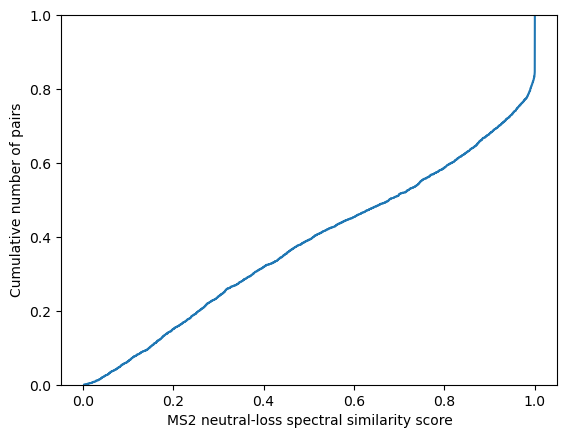

In [48]:
nl_data_spectra = merged_node_data['spectrum_nl_spectra'].tolist()
data_pmzs = merged_node_data['precursor_mz'].tolist()
shifted_spectra = []
for s,pmz in zip(nl_data_spectra,data_pmzs):
    temp = s.copy()
    temp[:,0] = pmz - temp[:,0]
    shifted_spectra.append(temp)

discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                        bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
msms_score_min = 0
msms_matches_min = 0
nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
nl_blink.reset_index(inplace=True,drop=False)
cols = ['ref','query']
nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
nl_blink.drop_duplicates(subset=cols,inplace=True)
nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
idx = nl_blink['score']>1
nl_blink.loc[idx,'score'] = 1
fig,ax = plt.subplots()
# temp = nl_blink[nl_blink['score']>0.001].copy()
# bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
# bins = np.linspace(nl_blink['score'].min(),nl_blink['score'].max(),100)
sns.ecdfplot(nl_blink['score'],ax=ax)
# ax.hist(nl_blink['score'],bins=bins)
ax.set_xlabel('MS2 neutral-loss spectral similarity score')
ax.set_ylabel('Cumulative number of pairs')
plt.show


In [52]:
import networkx as nx

# Filter the merged_node_data based on nl_blink_score > 0.9
filtered_data = nl_blink[nl_blink['score'] > 0.95]

network = nx.from_pandas_edgelist(filtered_data, source='ref', target='query')
nx.write_graphml(network, 'network.graphml')
# Optional: You can further customize the network visualization or perform network analysis using NetworkX functions.

<function matplotlib.pyplot.show(close=None, block=None)>

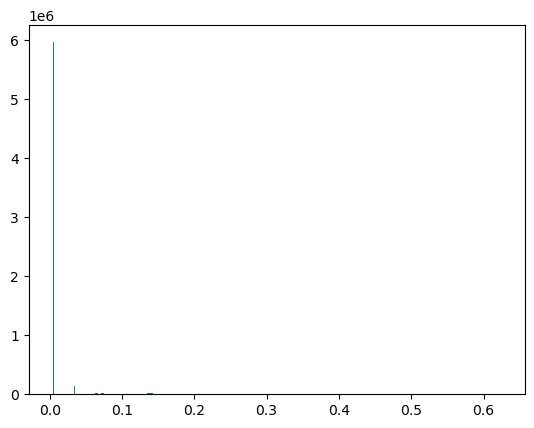

In [22]:
import seaborn as sns
fig,ax = plt.subplots()
temp = rem_df[rem_df['rem_blink_score']>0.001].copy()
bins = np.logspace(np.log10(temp['rem_blink_score'].min()),np.log10(temp['rem_blink_score'].max()),100)
ax.hist(temp['rem_blink_score'],bins=bins)
plt.show